# Building model from Judson et al using PyTorch


First load the data from receptors collection in the MongoDB. Just based on the previous notebooks, focus on the ToxCast aeids that were relevant to human endpoints (i.e., human_hc and human_hb)

In [2]:
import pandas as pd, numpy as np 
import pymongo, toxcast

client = pymongo.MongoClient()

receptors = pd.DataFrame(client.LiverToxCast.endpoint_aeid_pvalues.find({}, {'_id': 0}))

In [3]:
human_aops = receptors
human_aops.head()

,endpoint,aeid,pvalue,odds,active_tox,active_nontox,inactive_tox,inactive_nontox,Rank,b-h_threshold,assay_component_endpoint_name,assay_function_type,intended_target_family_sub,mechanism_group,mechanism_group2,official_symbol,organism_id,source
0,human_hb,2093,7.354057e-09,2.021375,228,161,358,511,1,0.000102,TOX21_RT_HEK293_GLO_40hr_viability,viability,cytotoxicity,CYTOTOXICITY,CYTOTOXICITY,NaN,NaN,NaN
1,human_hb,2119,1.065470e-07,1.988314,188,129,398,543,2,0.000205,TOX21_ERb_BLA_Antagonist_ratio,reporter gene,steroidal,ER_ANTAGONIST,ER_ANTAGONIST,ESR2,1,gene
2,human_hb,2369,1.923410e-07,1.986672,178,121,408,551,3,0.000307,TOX21_CASP3_CHO_viability,viability,cytotoxicity,CYTOTOXICITY,CYTOTOXICITY,NaN,NaN,NaN
3,human_hb,2362,2.264877e-07,1.927098,196,139,390,533,4,0.000410,TOX21_PXR_viability,viability,cytotoxicity,CYTOTOXICITY,CYTOTOXICITY,NaN,NaN,NaN
4,human_hb,2091,3.087792e-07,1.863409,219,163,367,509,5,0.000512,TOX21_RT_HEK293_GLO_32hr_viability,viability,cytotoxicity,CYTOTOXICITY,CYTOTOXICITY,NaN,NaN,NaN


In [8]:
human_ke = human_aops.rename({'mechanism_group2': 'KE'}, axis=1)

In [11]:
print(human_ke.KE.value_counts())

CYTOTOXICITY                68
CONTROL                     23
TP53                         7
CYP_DN                       6
ER_ANTAGONIST                5
AR_ANTAGONIST                4
OXIDATIVE_STRESS             4
TR_ANTAGONIST                3
TRANSPORTER_DOWN             3
PPAR_ANTAGONIST              3
PR_ANTAGONIST                3
CELL_ARREST                  3
AR_AGONIST                   3
DNA_REPAIR                   3
AR_AGONIST;AR_ANTAGONIST     2
ESRA_ANTAGONIST              2
TGFB_ANTAGONIST              2
FMO3_DN                      2
ERG1_UP                      2
MITO                         2
THRA_ANTAGONIST              2
CELL_PROLIF                  2
GR_ANTAGONIST                2
PEG_DN                       2
CELL_PROLIF_UP               2
CAR_ANTAGONIST               2
TGFB_AGONIST                 2
ZEBRAFISH                    1
FXR_ANTAGONIST               1
HMGCS2_DN                    1
THRSP_DN                     1
DDIT3_UP                     1
CYP_UP  

At least one assay in involved in two AOPs, seperated by a ';'.  Need to split and explode these. 

In [12]:
print(human_ke.aeid.nunique())

157


In [16]:
human_ke.loc[:, 'KE'] = human_ke.KE.apply(lambda x: x.split(';'))
human_ke = human_ke.explode('KE')

In [20]:
receptor_data = human_ke.copy()


### F matrix

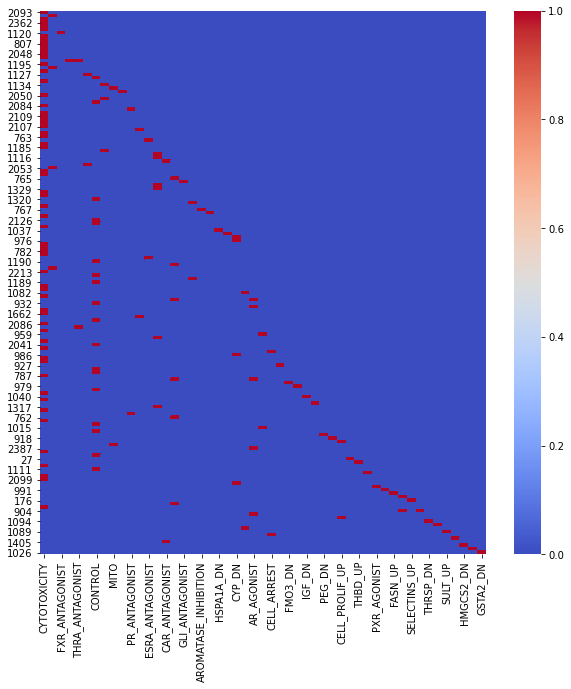

In [22]:
F_matrix = pd.DataFrame(index=receptor_data.aeid.unique().astype(int), columns=receptor_data.KE.unique())

for aop, aop_data in receptor_data.groupby('KE'):
    for aeid in aop_data.aeid.unique():
        F_matrix.loc[aeid, aop] = 1
F_matrix = F_matrix.fillna(0)

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(F_matrix, cmap='coolwarm')

### Data gathering

Get dose response data from best models db

Unlike the previous notebooks, instead of only getting compounds with liver toxicity data, make a model using the full dataset

In [23]:
client = pymongo.MongoClient()

master = client.LiverToxCast.modeling_set
liver_chems = list(master.find({'casn': {'$exists': True}}))
casrns = [r['casn'] for r in liver_chems]

modelsdb = client.LiverToxCast.best_models

# restrict to only aeids
# and casn 
dr_results  = list(modelsdb.find({'$and': [{'_id.aeid': {'$in': F_matrix.index.values.tolist()}}, 
                                            {'_id.casn': {'$in': casrns}}]}))

reformat = [{'aeid': r['_id']['aeid'], 'casn': r['_id']['casn'], 'responses': r['responses']}
           for r in dr_results]

CONC_LIST = dr_results[0]['concentrations']
cr_frame = pd.DataFrame(reformat)
frames = {}
IMPUTE_DATA = True

cas_numbers = []

for cas, data in cr_frame.groupby('casn'):
    df = pd.concat([data['aeid'], data['responses'].apply(pd.Series)], axis = 1)
    df = df.set_index('aeid')
    df.columns = CONC_LIST
    if IMPUTE_DATA:
        for assay in F_matrix.index:
            if assay not in df.index:
                df.loc[assay] = [0]*len(CONC_LIST)
        df = df.loc[F_matrix.index]
    frames[cas] = df.fillna(0)
    cas_numbers.append(cas)

In [24]:
cr_responses = np.stack([frames[cas].values for cas in cas_numbers], axis=2)

### Data normalization

In [25]:
cr_norm = cr_responses.copy()

for assay in range(cr_norm.shape[0]):
    scaler = cr_responses[assay, :, :].max()
    if scaler != 0:
        scale = 1/scaler
    else: 
        scale = 0
    
    cr_norm[assay, :, :] = cr_responses[assay, :, :] * scale

### PyTorch

In [26]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

#### PyTorch parameters

In [27]:
EPOCHS = 750
STEPS = 100
INITIAL_LR = 1
GAMMA = 0.5

#### Model variables

In [28]:
cr_responses_tmp = cr_norm[:, :, :]

F = torch.tensor(F_matrix.values, dtype=torch.float)

# Seems like the random initilaiztion works
# a little better
# R = torch.tensor(np.zeros(shape=(F.shape[1], len(CONC_LIST), cr_responses_tmp.shape[2])), 
#                  dtype=torch.float, requires_grad=True)

R = torch.tensor(np.random.random(size=(F.shape[1], len(CONC_LIST), cr_responses_tmp.shape[2])), 
                 dtype=torch.float, requires_grad=True)

# R = torch.tensor(torch.clamp(R, min=0, max=1), requires_grad=True)


y = torch.tensor(cr_responses_tmp)

optimizer = optim.Adam([R], lr=INITIAL_LR)
#scheduler = StepLR(optimizer, step_size=STEPS, gamma=0.9)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=50)


losses = np.array([])

#### Main loop- model training

In [29]:
for epoch in range(EPOCHS):
    # model is y = FR
    optimizer.zero_grad()
    #R = torch.clamp(R, min=0, max=1)
    model = torch.tensordot(F, R, dims=([1], [0]))


    ss_term = torch.mean(torch.square(model - y))

    x = torch.sum(R)
    penalty_term = x ** 10 / (x ** 10 + 0.5 ** 10)
    
    loss = ss_term + penalty_term
    loss = ss_term
    
    loss.backward()
    optimizer.step()
    losses = np.append(losses, loss.detach().numpy())
#     if losses[-50:].var() < 0.1 and epoch>10:
#         #print("Reducing LR...")
#         for g in optimizer.param_groups:
#             g['lr'] = g['lr']*GAMMA
    scheduler.step(loss)
    if epoch % STEPS == 0:
        print(loss)
        print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))

tensor(0.3512, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-0 lr: 1
tensor(0.0008, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-100 lr: 1
tensor(0.0008, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-200 lr: 1
tensor(0.0008, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-300 lr: 0.010000000000000002
tensor(0.0008, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-400 lr: 0.00010000000000000003
tensor(0.0008, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-500 lr: 1.0000000000000004e-06
tensor(0.0008, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-600 lr: 1.0000000000000005e-08
tensor(0.0008, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch-700 lr: 1.0000000000000005e-08


#### Model Plotting

Just some basic modeling to see if there of the models look ok. 

The second plot is a plot of the compounds with the highest resonse value for each receptor

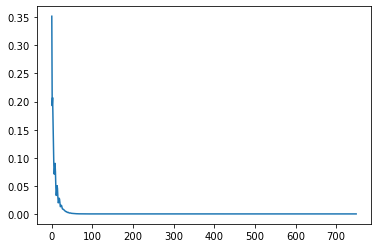

In [30]:
import matplotlib.pylab as plt

plt.plot(losses)
plt.show()

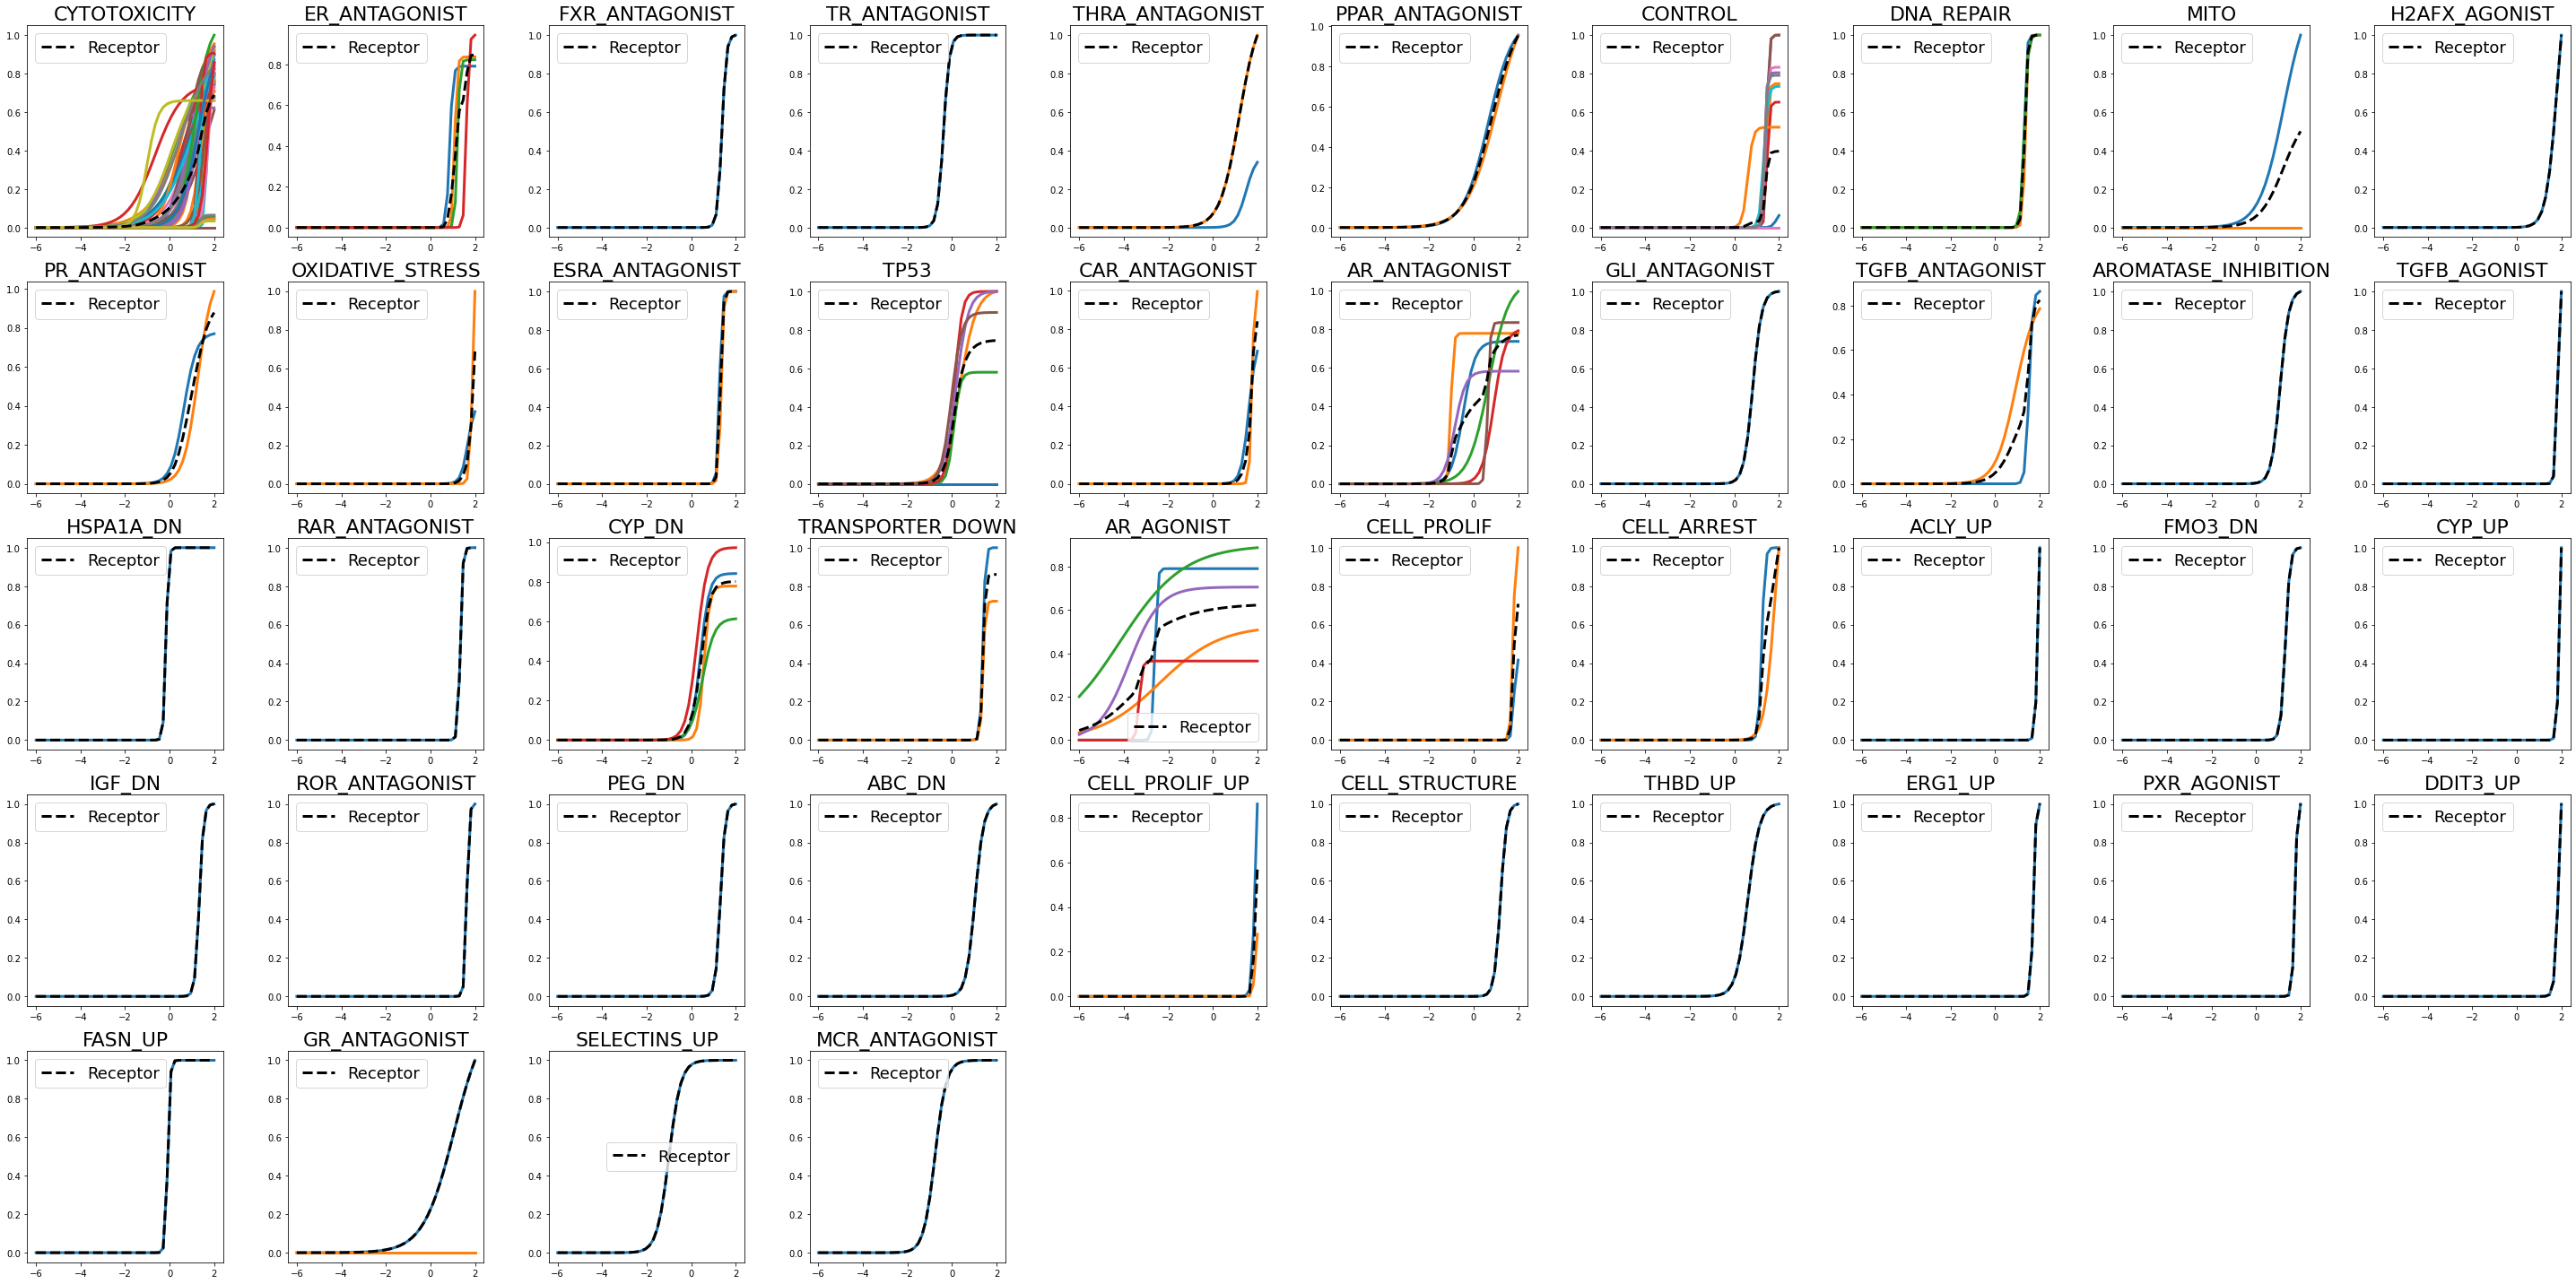

In [32]:
import math

rs = np.argmax(R.detach().numpy().max(1), axis=1)

xs = [math.log10(x) for x in CONC_LIST]

fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(40, 20))

for idx, r in enumerate(rs[:50]):
    scores = R[idx, :, r].detach().numpy()
    aeids = np.argwhere(F_matrix.iloc[:, idx].values == 1).reshape(1, -1)[0]
    assays = cr_norm[aeids, :, r-1]
    
    for assay in aeids:
        ax.flatten()[idx].plot(xs, cr_norm[assay, :, r], lw=3, )
    
    ax.flatten()[idx].plot(xs, scores, '--k', lw=3, label='Receptor')
    receptor = F_matrix.columns[idx]
    ax.flatten()[idx].set_title(receptor, fontsize=22)
    ax.flatten()[idx].legend(fontsize=18)
for a in ax[4][4:]:
    fig.delaxes(a)
plt.tight_layout()


### Model scoring

In [33]:
from toxcast import auc_score

scores = R.detach().numpy()

cmp_score_dic = {}

for i, casnumber in enumerate(cas_numbers):
    cmp_r_scores = pd.DataFrame(scores[:, :, i], index=F_matrix.columns, columns=CONC_LIST)
    cmp_auc_scores = auc_score(cmp_r_scores)
    cmp_score_dic[casnumber] = (cmp_r_scores, cmp_auc_scores)


In [34]:
d = [cmp_score_dic[cas][1] for cas in cas_numbers]

score_frame = pd.DataFrame(d, index=cas_numbers)

#### Normalize AUC scores

In [35]:
score_frame_norm = score_frame.divide(score_frame.max()).fillna(0)

In [36]:
scores_norm = scores.copy()

for r in range(scores_norm.shape[0]):
    scaler = scores[r, :, :].max()
    if scaler != 0:
        scores_norm[r, :, :] = scores_norm[r, :, :]*1/scaler

cmp_score_norm_dic = {}

for i, casnumber in enumerate(cas_numbers):
    cmp_r_scores = pd.DataFrame(scores_norm[:, :, i], index=F_matrix.columns, columns=CONC_LIST)
    cmp_score_norm_dic[casnumber] = cmp_r_scores


In [39]:
ke_models = client.LiverToxCast.ke_models

In [40]:
records_to_add = []

for cas in cas_numbers:
    
    cr_plots = cmp_score_dic[cas][0]
    cr_plots_norm = cmp_score_norm_dic[cas]
    
    for aop in cr_plots.index:
        
        record = {'_id': {'aop': aop, 'casn': cas, 'type': 'human'}}
                   
        aop_plot = cr_plots.loc[aop]
        aop_plot_norm = cr_plots_norm.loc[aop]
        
        record['concentrations'] = aop_plot.index.tolist()
        record['responses'] = aop_plot.values.tolist()
        record['responses_norm'] = aop_plot_norm.values.tolist()
        
        record['auc'] = float(score_frame.loc[cas, aop])
        record['auc_norm'] = float(score_frame_norm.loc[cas, aop])
    
        records_to_add.append(record)
    
ke_models.insert_many(records_to_add)